<h1 style='color:slategray; font-family:Akronim; font-Size:200%;' class='font-effect-fire-animation'> &#x1F310; &nbsp; Python Modules, Styling, Helpful Functions, and Links</h1>
#### [Github Version](https://github.com/OlgaBelitskaya/deep_learning_projects/blob/master/DL_PP4) & [Colaboratory Version](https://colab.research.google.com/drive/1r5yRD-3tQwN6lSql_VRoVuwQ8DaY5zUt)

In [1]:
%%html
<style> 
@import url('https://fonts.googleapis.com/css?family=Akronim|Roboto&effect=3d|fire-animation');
body {background-color: gainsboro;} 
a,h4 {color:#37c9e1; font-family:Roboto;} 
span {color:black; text-shadow:4px 4px 4px #aaa;}
div.output_prompt,div.output_area pre {color:slategray;}
div.input_prompt,div.output_subarea {color:#37c9e1;}      
div.output_stderr pre {background-color:gainsboro;}  
div.output_stderr {background-color:slategrey;}       
</style>

In [2]:
import warnings; warnings.filterwarnings('ignore')
import h5py,cv2,keras as ks,tensorflow as tf
import pandas as pd,numpy as np,pylab as pl
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential,load_model,Model
from keras.layers import Input,Activation,Dense,LSTM
from keras.layers import Flatten,Dropout,BatchNormalization
from keras.layers import Conv2D,MaxPooling2D,GlobalMaxPooling2D
from keras.layers import GlobalAveragePooling2D
from keras.layers.advanced_activations import PReLU,LeakyReLU
np.set_printoptions(precision=6)
fw='weights.style.hdf5'
dr2,dr25,dr3,dr5=.2,.25,.3,.5
fr2,fr5,fr8,al=.2,.5,.8,.02
from keras import __version__
print('keras version:', __version__)
print('tensorflow version:', tf.__version__)

Using TensorFlow backend.


keras version: 2.3.1
tensorflow version: 2.1.0


In [3]:
def ohe(x): 
    return OneHotEncoder(categories='auto')\
           .fit(x.reshape(-1,1)).transform(x.reshape(-1,1))\
           .toarray().astype('int64')
def tts(X,y): 
    x_train,x_test,y_train,y_test=\
    train_test_split(X,y,test_size=.2,random_state=1)
    n=int(len(x_test)/2)
    x_valid,y_valid=x_test[:n],y_test[:n]
    x_test,y_test=x_test[n:],y_test[n:]
    return x_train,x_valid,x_test,y_train,y_valid,y_test
def history_plot(fit_history):
    keys=list(fit_history.history.keys())[6:]
    pl.figure(figsize=(12,10)); pl.subplot(211)
    pl.plot(fit_history.history[keys[0]],
            color='slategray',label='valid 1')
    pl.plot(fit_history.history[keys[1]],
            color='#37c9e1',label='valid 2')
    pl.xlabel("Epochs"); pl.ylabel("Loss")
    pl.legend(); pl.grid(); pl.title('Loss Function')     
    pl.subplot(212)
    pl.plot(fit_history.history[keys[2]],
            color='slategray',label='valid 1')
    pl.plot(fit_history.history[keys[3]],
            color='#37c9e1',label='valid 2')
    pl.xlabel("Epochs"); pl.ylabel("Accuracy")    
    pl.legend(); pl.grid(); pl.title('Accuracy'); pl.show()

In [4]:
tpu=tf.distribute.cluster_resolver.TPUClusterResolver()
tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy=tf.distribute.experimental.TPUStrategy(tpu)

<h1 style='color:slategray; font-family:Akronim; font-Size:200%;' class='font-effect-fire-animation'> &#x1F310; &nbsp; Loading and Preprocessing the Data</h1>

In [5]:
data=pd.read_csv("../input/style/style.csv")
data.tail()

,brand_name,brand_label,product_name,product_label,file
2179,Yves Saint Laurent,6,earrings,9,6_9_017.png
2180,Yves Saint Laurent,6,earrings,9,6_9_018.png
2181,Yves Saint Laurent,6,earrings,9,6_9_019.png
2182,Yves Saint Laurent,6,earrings,9,6_9_020.png
2183,Yves Saint Laurent,6,earrings,9,6_9_021.png


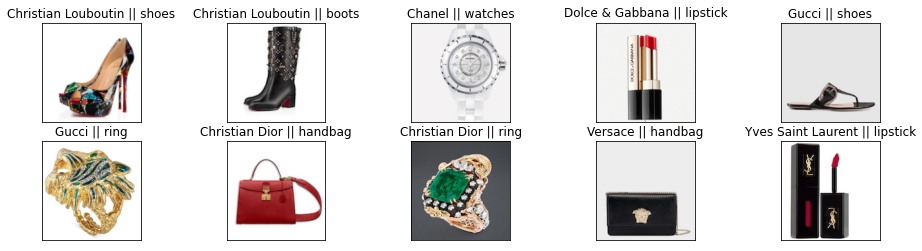

In [6]:
def display_images(img_path,ax):
    img=cv2.imread("../input/style/"+img_path)
    ax.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))    
fig=pl.figure(figsize=(16,4))
for i in range(10):
    ax=fig.add_subplot(2,5,i+1,xticks=[],yticks=[], 
                       title=data['brand_name'][i*218]+\
                       ' || '+data['product_name'][i*218])
    display_images(data['file'][i*218],ax)

In [7]:
f=h5py.File('../input/StyleColorImages.h5','r')
keys=list(f.keys())
brands=np.array(f[keys[0]])
images=np.array(f[keys[1]])/255 # normalization
products=np.array(f[keys[2]])

Product:  lipstick
Brand:  Christian Louboutin


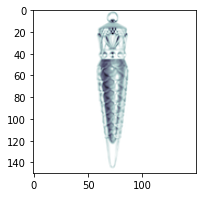

In [8]:
gray_images=np.dot(images[...,:3],[.299,.587,.114])
print('Product: ',data['product_name'][100])
print('Brand: ',data['brand_name'][100])
pl.figure(figsize=(3,3))
pl.imshow(gray_images[100],cmap=pl.cm.bone); pl.show()
gray_images=gray_images.reshape(-1,150,150,1)

In [9]:
cbrands,cproducts=ohe(brands),ohe(products)
ctargets=np.concatenate((cbrands,cproducts),axis=1)
pd.DataFrame([images.shape,gray_images.shape,
              cbrands.shape,cproducts.shape,ctargets.shape])

,0,1,2,3
0,2184,150,150.0,3.0
1,2184,150,150.0,1.0
2,2184,7,NaN,NaN
3,2184,10,NaN,NaN
4,2184,17,NaN,NaN


In [10]:
# Color Images / Multi-Label Target
x_train5,x_valid5,x_test5,\
y_train5,y_valid5,y_test5=tts(images,ctargets)
# Grayscaled Images / Multi-Label Target 
x_train6,x_valid6,x_test6,\
y_train6,y_valid6,y_test6=tts(gray_images,ctargets)
y_train5_list=[y_train5[:,:7],y_train5[:,7:]]
y_test5_list=[y_test5[:,:7],y_test5[:,7:]]
y_valid5_list=[y_valid5[:,:7],y_valid5[:,7:]]
y_train6_list=[y_train6[:,:7],y_train6[:,7:]]
y_test6_list=[y_test6[:,:7],y_test6[:,7:]]
y_valid6_list=[y_valid6[:,:7],y_valid6[:,7:]]
sh=[el.shape for el in \
[x_train5,y_train5,x_valid5,y_valid5,x_test5,y_test5,
 x_train6,y_train6,x_valid6,y_valid6,x_test6,y_test6]]
pd.DataFrame(sh)

,0,1,2,3
0,1747,150,150.0,3.0
1,1747,17,NaN,NaN
2,218,150,150.0,3.0
3,218,17,NaN,NaN
4,219,150,150.0,3.0
5,219,17,NaN,NaN
6,1747,150,150.0,1.0
7,1747,17,NaN,NaN
8,218,150,150.0,1.0
9,218,17,NaN,NaN


<h1 style='color:slategray; font-family:Akronim; font-Size:200%;' class='font-effect-fire-animation'> &#x1F310; &nbsp;Multi-Label Classification Models</h1>
We should have an accuracy 

- greater than 14.3% for the first target (`brand`) and 

- greater than 10% for the second target (`product`).

In [11]:
# Color Images
def mmodel():    
    model_input=Input(shape=(150,150,3))
    x=BatchNormalization()(model_input)
    x=Conv2D(32,(5,5),padding='same')(model_input)
    x=LeakyReLU(alpha=al)(x)
    x=MaxPooling2D(pool_size=(2,2))(x)    
    x=Dropout(dr25)(x)   
    x=Conv2D(256,(5,5),padding='same')(x)       
    x=MaxPooling2D(pool_size=(2,2))(x)    
    x=Dropout(dr25)(x)              
    x=GlobalMaxPooling2D()(x)   
    x=Dense(512)(x)
    x=LeakyReLU(alpha=al)(x)    
    x=Dropout(dr25)(x)     
    y1=Dense(7,activation='softmax')(x)
    y2=Dense(10,activation='softmax')(x)   
    model=Model(inputs=model_input,outputs=[y1,y2])    
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',metrics=['accuracy'])
    return model
with tpu_strategy.scope():
    mmodel=mmodel()

In [12]:
checkpointer=ModelCheckpoint(filepath=fw,verbose=2,save_best_only=True)
lr_reduction=ReduceLROnPlateau(monitor='val_loss',patience=5,
                               verbose=2,factor=fr8)
estopping=EarlyStopping(monitor='val_loss',patience=25,verbose=2)
history=mmodel.fit(x_train5,y_train5_list,
                   validation_data=(x_valid5,y_valid5_list),
                   epochs=150,batch_size=128,verbose=2,
                   callbacks=[checkpointer,lr_reduction,estopping])

Train on 1747 samples, validate on 218 samples
Epoch 1/150
 - 19s - loss: 4.1852 - dense_2_loss: 1.9696 - dense_3_loss: 2.2101 - dense_2_accuracy: 0.1878 - dense_3_accuracy: 0.2026 - val_loss: 4.0749 - val_dense_2_loss: 1.9171 - val_dense_3_loss: 2.1614 - val_dense_2_accuracy: 0.2339 - val_dense_3_accuracy: 0.2294

Epoch 00001: val_loss improved from inf to 4.07486, saving model to weights.style.hdf5
Epoch 2/150
 - 18s - loss: 4.0047 - dense_2_loss: 1.8938 - dense_3_loss: 2.1108 - dense_2_accuracy: 0.2484 - dense_3_accuracy: 0.2461 - val_loss: 3.9365 - val_dense_2_loss: 1.8662 - val_dense_3_loss: 2.0733 - val_dense_2_accuracy: 0.2569 - val_dense_3_accuracy: 0.2477

Epoch 00002: val_loss improved from 4.07486 to 3.93645, saving model to weights.style.hdf5
Epoch 3/150
 - 19s - loss: 3.8355 - dense_2_loss: 1.8404 - dense_3_loss: 1.9925 - dense_2_accuracy: 0.2610 - dense_3_accuracy: 0.2547 - val_loss: 3.8640 - val_dense_2_loss: 1.8206 - val_dense_3_loss: 2.0464 - val_dense_2_accuracy: 0.29

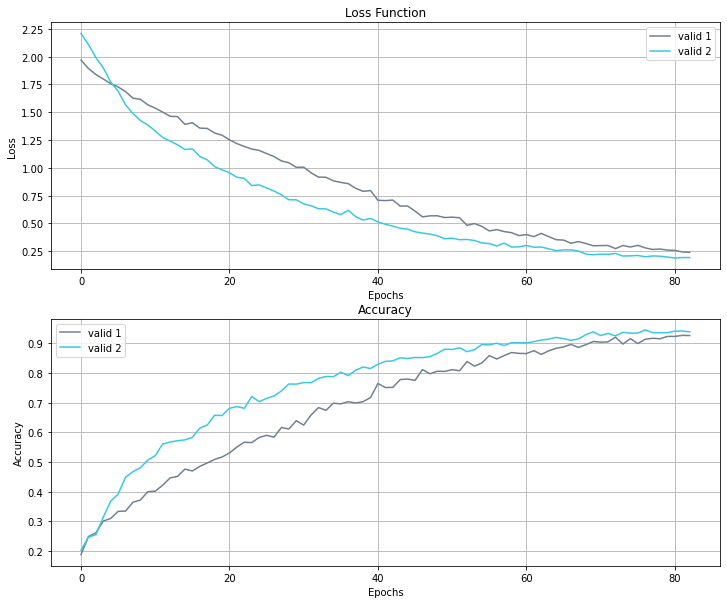

In [13]:
history_plot(history)

In [14]:
mmodel.load_weights(fw)
scores=mmodel.evaluate(x_test5,y_test5_list)
print("Scores: \n",(scores))
print("The Brand Label. Accuracy: %.2f%%"%(scores[3]*100))
print("The Product Label. Accuracy: %.2f%%"%(scores[4]*100))

219/219 [==============================] - 0s 2ms/step
Scores: 
 [2.19548937229261, 1.1278058290481567, 1.061288833618164, 0.6529680490493774, 0.7077625393867493]
The Brand Label. Accuracy: 65.30%
The Product Label. Accuracy: 70.78%


In [15]:
# Grayscaled Images
def gray_mmodel():    
    model_input=Input(shape=(150,150,1))
    x=BatchNormalization()(model_input)
    x=Conv2D(32,(5,5),padding='same')(model_input)
    x=LeakyReLU(alpha=al)(x)
    x=MaxPooling2D(pool_size=(2,2))(x)    
    x=Dropout(dr25)(x)    
    x=Conv2D(256,(5,5),padding='same')(x)
    x=LeakyReLU(alpha=al)(x)       
    x=MaxPooling2D(pool_size=(2,2))(x)    
    x=Dropout(dr25)(x)             
    x=GlobalMaxPooling2D()(x)    
    x=Dense(1024)(x)
    x=LeakyReLU(alpha=al)(x)   
    x=Dropout(dr25)(x)   
    x=Dense(256)(x)
    x=LeakyReLU(alpha=al)(x)    
    x=Dropout(dr25)(x)    
    y1=Dense(7,activation='softmax')(x)
    y2=Dense(10,activation='softmax')(x)       
    model=Model(inputs=model_input,outputs=[y1,y2])
    model.compile(loss='categorical_crossentropy',
                  optimizer='rmsprop',metrics=['accuracy'])   
    return model
with tpu_strategy.scope():
    gray_mmodel=gray_mmodel()

In [16]:
checkpointer=ModelCheckpoint(filepath=fw,verbose=2,save_best_only=True)
lr_reduction=ReduceLROnPlateau(monitor='val_loss',patience=5,
                               verbose=2,factor=fr5)
estopping=EarlyStopping(monitor='val_loss',patience=25,verbose=2)
history=gray_mmodel.fit(x_train6,y_train6_list,
                        validation_data=(x_valid6,y_valid6_list),
                        epochs=150,batch_size=128,verbose=2,
                        callbacks=[checkpointer,lr_reduction,estopping])

Train on 1747 samples, validate on 218 samples
Epoch 1/150
 - 17s - loss: 4.2120 - dense_6_loss: 1.9478 - dense_7_loss: 2.2642 - dense_6_accuracy: 0.2038 - dense_7_accuracy: 0.1860 - val_loss: 4.1450 - val_dense_6_loss: 1.9288 - val_dense_7_loss: 2.2190 - val_dense_6_accuracy: 0.2339 - val_dense_7_accuracy: 0.2202

Epoch 00001: val_loss improved from inf to 4.14495, saving model to weights.style.hdf5
Epoch 2/150
 - 16s - loss: 4.0731 - dense_6_loss: 1.9248 - dense_7_loss: 2.1491 - dense_6_accuracy: 0.2135 - dense_7_accuracy: 0.1969 - val_loss: 4.0703 - val_dense_6_loss: 1.9046 - val_dense_7_loss: 2.1693 - val_dense_6_accuracy: 0.2385 - val_dense_7_accuracy: 0.2202

Epoch 00002: val_loss improved from 4.14495 to 4.07031, saving model to weights.style.hdf5
Epoch 3/150
 - 16s - loss: 3.9654 - dense_6_loss: 1.9127 - dense_7_loss: 2.0512 - dense_6_accuracy: 0.2330 - dense_7_accuracy: 0.2479 - val_loss: 3.8811 - val_dense_6_loss: 1.8825 - val_dense_7_loss: 2.0017 - val_dense_6_accuracy: 0.26

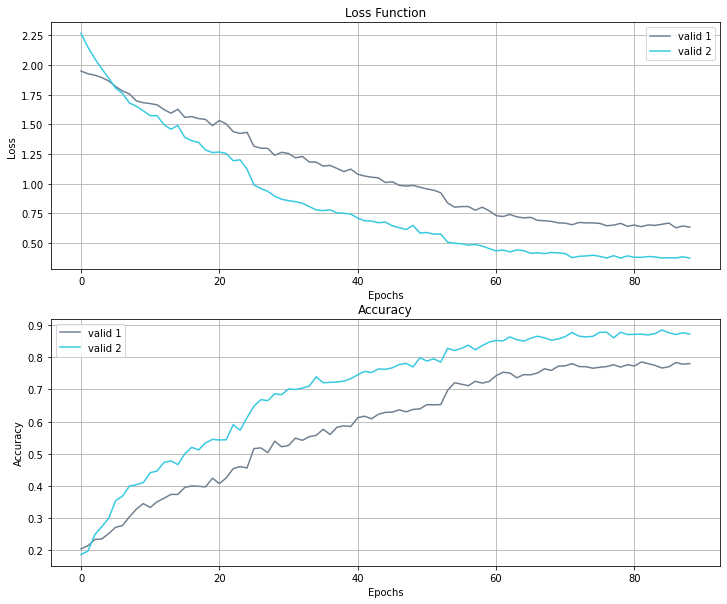

In [17]:
history_plot(history)

In [18]:
gray_mmodel.load_weights(fw)
scores=gray_mmodel.evaluate(x_test6,y_test6_list)
print("Scores: \n",(scores))
print("The Brand Label. Accuracy: %.2f%%"%(scores[3]*100))
print("The Product Label. Accuracy: %.2f%%"%(scores[4]*100))

219/219 [==============================] - 0s 2ms/step
Scores: 
 [2.2215786339485484, 1.2861223220825195, 0.9330110549926758, 0.5296803712844849, 0.6849315166473389]
The Brand Label. Accuracy: 52.97%
The Product Label. Accuracy: 68.49%
